In [156]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [52]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [53]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [54]:
table_names = ['corruption_perception', 'life_expectancy', \
               'population_0_14', 'population_15_64', 'population_65_up', \
               'population_female', 'under_5_mortality', 'zscores']

In [55]:
query = makeSQLQuery(table_names, 2013)

In [56]:
data_2013 = pd.read_sql_query(query, engine)

In [57]:
data_2013 = data_2013.set_index('countrycode')

In [58]:
data_2013['zscores'] = data_2013['zscores'].astype(float)

In [59]:
data_2013.head()

,corruption_perception,life_expectancy,population_0_14,population_15_64,population_65_up,population_female,under_5_mortality,zscores
countrycode,,,,,,,,
AFG,8,60.028268,45.685257,51.920329,2.394414,48.507090,96.7,6.005490
AGO,23,51.866171,48.012577,49.673340,2.314084,50.407447,167.1,-0.232733
ALB,31,77.537244,19.382294,68.848024,11.769682,50.073406,14.9,-0.003833
ARE,69,77.195634,13.718086,85.340053,0.941861,25.883957,7.4,-0.265036
ARG,34,75.986098,25.465743,63.834426,10.699832,51.078024,13.3,-0.265098


In [60]:

data_2013.loc[data_2013['zscores'] > 0, 'zscores'] = 1
data_2013.loc[data_2013['zscores'] <= 0, 'zscores'] = 0


In [61]:
#The rows to be dropped
data_2013[data_2013.isnull().any(axis=1)]

,corruption_perception,life_expectancy,population_0_14,population_15_64,population_65_up,population_female,under_5_mortality,zscores
countrycode,,,,,,,,
BLZ,NaN,69.982049,33.722069,62.518994,3.758938,50.087015,17.5,0
FJI,NaN,69.917927,28.845400,65.713066,5.441534,49.063189,23.2,0
GRD,NaN,73.193561,26.765311,66.079961,7.154728,49.912183,12.5,0
KIR,NaN,65.766585,35.356169,61.033314,3.610517,50.731501,58.9,0
MDV,NaN,76.602610,27.715737,67.509135,4.775128,49.858307,9.9,0
SLB,NaN,67.718927,40.113611,56.518544,3.367845,49.245833,29.9,0
TON,NaN,72.640341,37.147015,56.966492,5.886493,49.883488,17.3,0
VUT,NaN,71.669244,37.171805,58.783797,4.044398,49.309739,28.4,0
WSM,NaN,73.250390,37.750932,57.108567,5.140501,48.440569,18.2,0


In [62]:
data_2013 = data_2013.dropna()

In [109]:
def getScoreValues(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6), verbose=True):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)

    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    
    return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value

In [64]:
X = data_2013[['corruption_perception', 'life_expectancy', 'population_0_14', \
               'population_15_64', 'population_65_up', 'population_female', 'under_5_mortality']]
y = data_2013['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [65]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.8627450980392157
Precision: 0.2857142857142857
Recall: 0.5
f1: 0.36363636363636365


In [66]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7843137254901961
Precision: 0.18181818181818182
Recall: 0.5
f1: 0.26666666666666666


In [68]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.9215686274509803
Precision: 0.0
Recall: 0.0
f1: 0.0


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9215686274509803
Precision: 0.5
Recall: 0.25
f1: 0.3333333333333333


In [70]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.6808510638297872


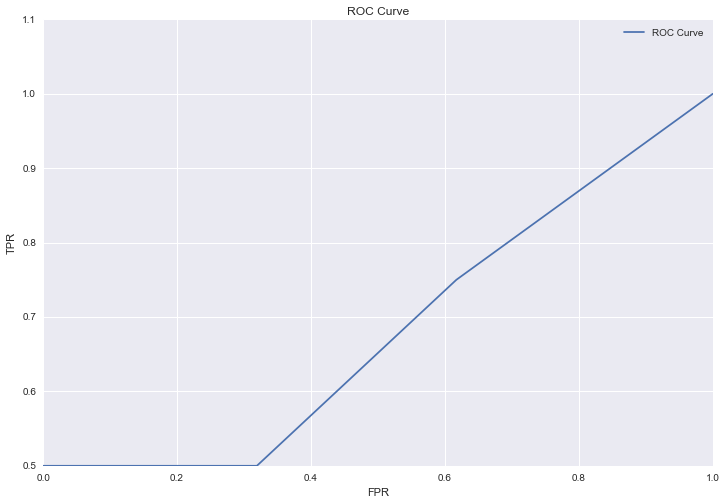

In [71]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [72]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [73]:
getScoreValuesByCV(X,y)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8282913165266107
Precision: 0.3833333333333333
Recall: 0.14666666666666667
f1: 0.2
ROC AUC: 0.657824302134647


In [74]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.8165164247517188
Precision: 0.3333333333333333
Recall: 0.22666666666666666
f1: 0.23158730158730162
ROC AUC: 0.6458538587848933


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7031168831168831
Precision: 0.29095238095238096
Recall: 0.54
f1: 0.3726934984520124
ROC AUC: 0.6926108374384236


In [76]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.7867481538069774
Precision: 0.3333333333333333
Recall: 0.30666666666666664
f1: 0.2883394383394383
ROC AUC: 0.587528735632184


In [77]:
getScoreValuesByCV(X,y, model=LogisticRegression())

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8526916221033869
Precision: 0.4
Recall: 0.08
f1: 0.13333333333333336
ROC AUC: 0.6611165845648603


/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Over sampling

In [78]:
x_cols = ['corruption_perception', 'life_expectancy', 'population_0_14', \
               'population_15_64', 'population_65_up', 'population_female', 'under_5_mortality']

In [79]:
X = data_2013[x_cols]
y = data_2013['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [80]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [81]:
smox

array([[  20.        ,   67.77204878,   32.10237394, ...,    3.93080535,
          51.24020431,   32.9       ],
       [  45.        ,   73.90141463,   36.10158906, ...,    3.76568713,
          48.68319872,   19.        ],
       [  41.        ,   74.46585366,   13.86624739, ...,   19.36866524,
          51.37638005,   11.5       ],
       ..., 
       [  36.11350686,   74.53841881,   19.05126791, ...,   10.41721483,
          51.58194318,   15.58618114],
       [  24.67299548,   51.92669139,   42.9254176 , ...,    3.1078171 ,
          49.22441804,   99.03580007],
       [  20.00903667,   52.30322868,   41.05753015, ...,    3.68303636,
          50.37438827,  120.66864918]])

In [82]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [83]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.803921568627451
Precision: 0.25
Recall: 0.75
f1: 0.375


In [84]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.0784313725490196
Precision: 0.0784313725490196
Recall: 1.0
f1: 0.14545454545454545


In [85]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.5098039215686274
Precision: 0.08
Recall: 0.5
f1: 0.13793103448275865


In [86]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.6470588235294118
Precision: 0.1111111111111111
Recall: 0.5
f1: 0.1818181818181818


In [87]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.6274509803921569
Precision: 0.10526315789473684
Recall: 0.5
f1: 0.17391304347826086


## Cross validate with oversampling

In [157]:
def getCrossValScoresBySKF(local_X, local_y, n_iter=30, test_size=0.3, model=KNeighborsClassifier(n_neighbors=6)):
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    for train_index, test_index in sss:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]
        
        X_train = X_train.reset_index(drop=True).as_matrix()
        y_train = y_train.reset_index(drop=True).as_matrix()

        smote = SMOTE(ratio=ratio, verbose=verbose)
        smox, smoy = smote.fit_transform(X_train, y_train)
        X_train = pd.DataFrame(smox, columns=x_cols)
        y_train = pd.Series(smoy)
        
        accuracy_score_value, precision_score_value, \
        recall_score_value, f1_score_value = \
        getScoreValues(X_train, X_test, y_train, y_test, model=model, verbose=False)
        
        acc_array.append(accuracy_score_value)
        prec_array.append(precision_score_value)
        recall_array.append(recall_score_value)
        f1_array.append(f1_score_value)
        
    mean_acc = np.mean(acc_array)
    mean_prec = np.mean(prec_array)
    mean_recall = np.mean(recall_array)
    mean_f1 = np.mean(f1_array)
    
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                   mean_prec, \
                                                                   mean_recall, \
                                                                   mean_f1))

In [158]:
X = data_2013[x_cols]
y = data_2013['zscores']

#### KNN various n


In [159]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySKF(X, y, model=KNeighborsClassifier(n_neighbors=n))
    print('\n')

n =  1
Accuracy: 0.6594771241830067
Precision: 0.1987550959532384
Recall: 0.37916666666666665
f1: 0.2585823884085002


n =  2
Accuracy: 0.7333333333333336
Precision: 0.22517536929301635
Recall: 0.2833333333333333
f1: 0.24387046344321883


n =  3
Accuracy: 0.6169934640522875
Precision: 0.21028336993982885
Recall: 0.5041666666666667
f1: 0.29408004628649903


n =  4
Accuracy: 0.6875816993464053
Precision: 0.2219955976555115
Recall: 0.3875
f1: 0.27784335501577306


n =  5
Accuracy: 0.6202614379084969
Precision: 0.22247834042502887
Recall: 0.55
f1: 0.3142250205514017


n =  6
Accuracy: 0.6450980392156864
Precision: 0.20813493531490573
Recall: 0.4625
f1: 0.28419601381570797


n =  7
Accuracy: 0.5823529411764706
Precision: 0.19480196990952311
Recall: 0.5333333333333333
f1: 0.2836740626353823




#### Logistic Regression

In [160]:
getCrossValScoresBySKF(X, y, model=LogisticRegression())

Accuracy: 0.5660130718954249
Precision: 0.1858952516731426
Recall: 0.5375
f1: 0.27410081049147994


#### GaussianNB

In [161]:
getCrossValScoresBySKF(X, y, model=GaussianNB())

Accuracy: 0.5516339869281045
Precision: 0.20459800094533703
Recall: 0.6458333333333334
f1: 0.30954712148944363


#### BernoulliNB

In [162]:
getCrossValScoresBySKF(X, y, model=BernoulliNB())

Accuracy: 0.15686274509803924
Precision: 0.15686274509803924
Recall: 1.0
f1: 0.27118644067796616


#### Random Forest

In [163]:
getCrossValScoresBySKF(X, y, model=RandomForestClassifier())

Accuracy: 0.7222222222222224
Precision: 0.23031033781033777
Recall: 0.31666666666666665
f1: 0.26128461881019427


#### DecisionTreeClassifier

In [164]:
getCrossValScoresBySKF(X, y, model=DecisionTreeClassifier())

Accuracy: 0.7130718954248368
Precision: 0.22745652495652496
Recall: 0.32916666666666666
f1: 0.2605402577037387
